# Predicting Sunshine Hours for Multiple Locations using LSTM

https://github.com/saravi1167/DTSA5511

## 1. Introduction
This report details the development of a multi-output deep learning model to simultaneously predict daily sunshine hours for multiple European locations (Basel, Budapest, etc.) present in the dataset. Using a historical weather dataset containing various meteorological variables from these locations, a single Long Short-Term Memory (LSTM) network was implemented. The model leverages shared weather patterns across locations to potentially improve predictions.

Accurate prediction of sunshine hours is valuable for various applications across different regions. By training a single model on data from multiple locations, the model is will learn shared underlying weather dynamics and potentially improve prediction accuracy compared to training separate models for each location, especially if data for some locations is sparse.

## 2. Setup and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

## 3. Exploratory Data Analysis

In [2]:
DATASET_PATH = "/Users/saravi/Documents/Data/Master's/weather-prediction/weather_prediction_dataset.csv"

df_raw = pd.read_csv(DATASET_PATH, parse_dates=['DATE'], index_col='DATE')

In [3]:
print(df_raw.info())

df_raw.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2000-01-01 to 2010-01-01
Columns: 164 entries, MONTH to TOURS_temp_max
dtypes: float64(150), int64(14)
memory usage: 4.6 MB
None


MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
DATE                                                                   
2000-01-01      1                  8            0.89          1.0286   
2000-01-02      1                  8            0.87          1.0318   
2000-01-03      1                  5            0.81          1.0314   
2000-01-04      1                  7            0.79          1.0262   
2000-01-05      1                  5            0.90          1.0246   

            BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
DATE                                                                      
2000-01-01                    0.20                 0.03             0.0   
2000-01-02                    0.25                 0.00             0.0   
2000-01-03                    0.50                 0.00             3.7   
2000-01-04                    0.63                 0.35             6.9   
2000-01-05                    0.51                 0.07             3.7   

            BASEL_temp_mean  BASEL_temp_min  BASEL_temp_max  ...  \
DATE                                                         ...   
2000-01-01              2.9             1.6             3.9  ...   
2000-01-02              3.6             2.7             4.8  ...   
2000-01-03              2.2             0.1             4.8  ...   
2000-01-04              3.9             0.5             7.5  ...   
2000-01-05              6.0             3.8             8.6  ...   

            STOCKHOLM_temp_min  STOCKHOLM_temp_max  TOURS_wind_speed  \
DATE                                                                   
2000-01-01                -9.3                 0.7               1.6   
2000-01-02                 0.5                 2.0               2.0   
2000-01-03                -1.0                 2.8               3.4   
2000-01-04                 2.5                 4.6               4.9   
2000-01-05                -1.8                 2.9               3.6   

            TOURS_humidity  TOURS_pressure  TOURS_global_radiation  \
DATE                                                                 
2000-01-01            0.97          1.0275                    0.25   
2000-01-02            0.99          1.0293                    0.17   
2000-01-03            0.91          1.0267                    0.27   
2000-01-04            0.95          1.0222                    0.11   
2000-01-05            0.95          1.0209                    0.39   

            TOURS_precipitation  TOURS_temp_mean  TOURS_temp_min  \
DATE                                                               
2000-01-01                 0.04              8.5             7.2   
2000-01-02                 0.16              7.9             6.6   
2000-01-03                 0.00              8.1             6.6   
2000-01-04                 0.44              8.6             6.4   
2000-01-05                 0.04              8.0             6.4   

            TOURS_temp_max  
DATE                        
2000-01-01             9.8  
2000-01-02             9.2  
2000-01-03             9.6  
2000-01-04            10.8  
2000-01-05             9.5  

[5 rows x 164 columns]

In [4]:
print("\nMissing values per column (raw dataset):")
print(df_raw.isnull().sum())


Missing values per column (raw dataset):
MONTH                     0
BASEL_cloud_cover         0
BASEL_humidity            0
BASEL_pressure            0
BASEL_global_radiation    0
                         ..
TOURS_global_radiation    0
TOURS_precipitation       0
TOURS_temp_mean           0
TOURS_temp_min            0
TOURS_temp_max            0
Length: 164, dtype: int64


In [5]:
sunshine_cols = [col for col in df_raw.columns if col.endswith('_sunshine')]
print(f"\nIdentified Sunshine (Target) Columns ({len(sunshine_cols)}):")
print(sunshine_cols)


Identified Sunshine (Target) Columns (14):
['BASEL_sunshine', 'BUDAPEST_sunshine', 'DE_BILT_sunshine', 'DRESDEN_sunshine', 'DUSSELDORF_sunshine', 'HEATHROW_sunshine', 'KASSEL_sunshine', 'LJUBLJANA_sunshine', 'MAASTRICHT_sunshine', 'MUENCHEN_sunshine', 'OSLO_sunshine', 'ROMA_sunshine', 'SONNBLICK_sunshine', 'STOCKHOLM_sunshine']


In [6]:
predictor_cols = [col for col in df_raw.columns if col != 'MONTH' and not col.endswith('_sunshine')]

print(f"\nIdentified Predictor Columns ({len(predictor_cols)}):")


Identified Predictor Columns (149):


In [7]:
all_relevant_cols = predictor_cols + sunshine_cols
df_processed = df_raw[all_relevant_cols].copy()

print(f"\nShape of DataFrame with relevant columns: {df_processed.shape}")


Shape of DataFrame with relevant columns: (3654, 163)


## 4. Data Preprocessing

In [8]:
initial_rows = df_processed.shape[0]
df_processed.dropna(subset=sunshine_cols, inplace=True)
rows_after_drop = df_processed.shape[0]

print(f"\nDropped {initial_rows - rows_after_drop} rows with missing values in any sunshine column.")


Dropped 0 rows with missing values in any sunshine column.


In [9]:
df_processed.fillna(method='ffill', inplace=True)
df_processed.fillna(method='bfill', inplace=True)

print("\nMissing values after handling:")
print(df_processed.isnull().sum().sum(), "total missing values remaining.") # Should be 0
print(df_processed.describe())


Missing values after handling:
0 total missing values remaining.
       BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
count        3654.000000     3654.000000     3654.000000   
mean            5.418446        0.745107        1.017876   
std             2.325497        0.107788        0.007962   
min             0.000000        0.380000        0.985600   
25%             4.000000        0.670000        1.013300   
50%             6.000000        0.760000        1.017700   
75%             7.000000        0.830000        1.022700   
max             8.000000        0.980000        1.040800   

       BASEL_global_radiation  BASEL_precipitation  BASEL_temp_mean  \
count             3654.000000          3654.000000      3654.000000   
mean                 1.330380             0.234849        11.022797   
std                  0.935348             0.536267         7.414754   
min                  0.050000             0.000000        -9.300000   
25%                  0.530000         

Text(0.5, 0, 'Date')

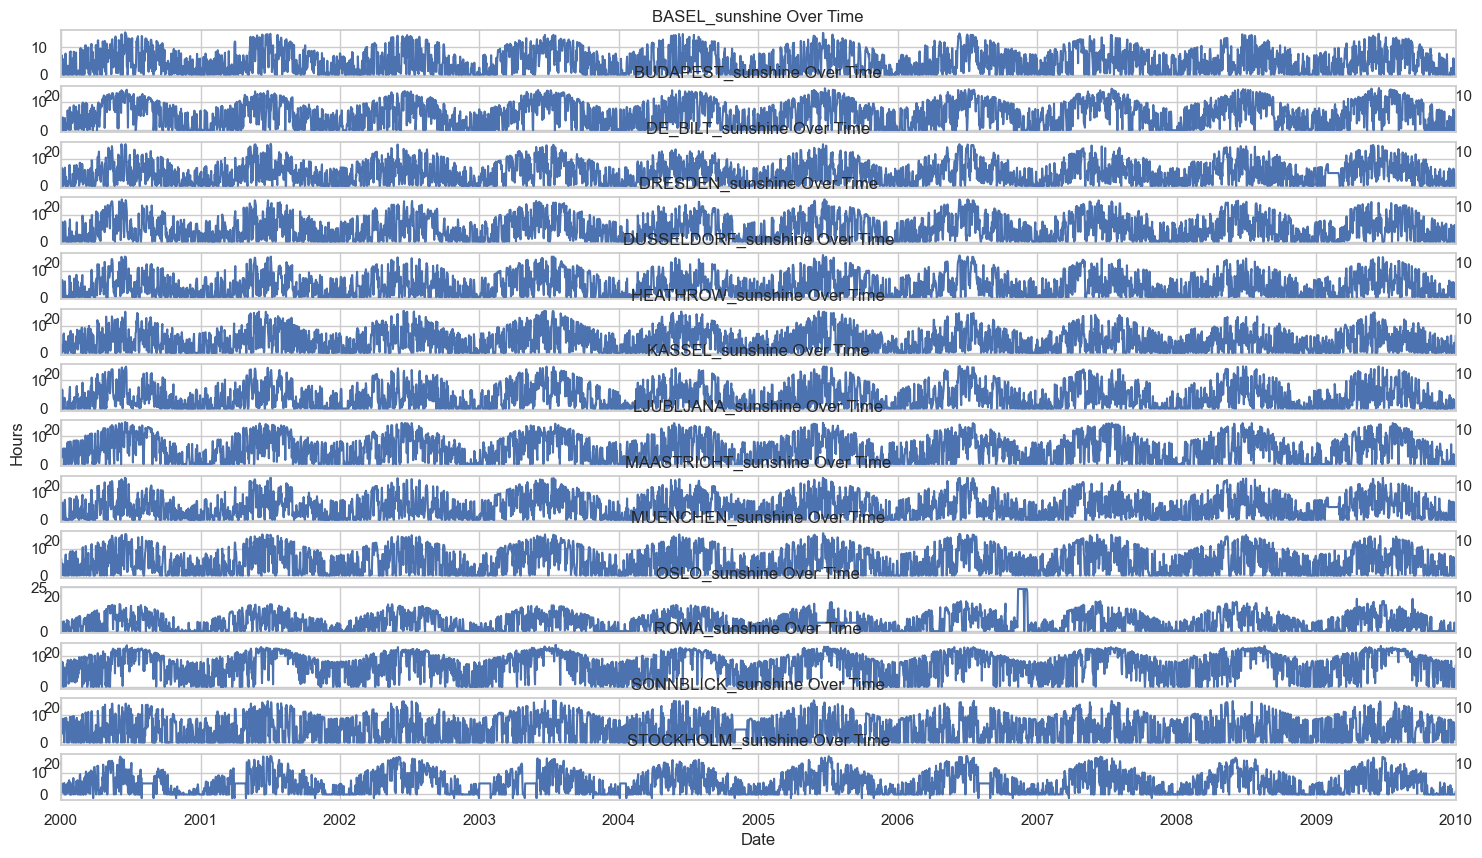

In [10]:
plt.figure(figsize=(18, 10))
for i, col in enumerate(sunshine_cols):
    plt.subplot(len(sunshine_cols), 1, i+1)
    df_processed[col].plot(title=f'{col} Over Time')
    plt.xlabel('') 
    if i == len(sunshine_cols) / 2:
        plt.ylabel('Hours')
plt.xlabel('Date')

Text(0.5, 1.0, 'Correlation of Features with Sunshine Hours')

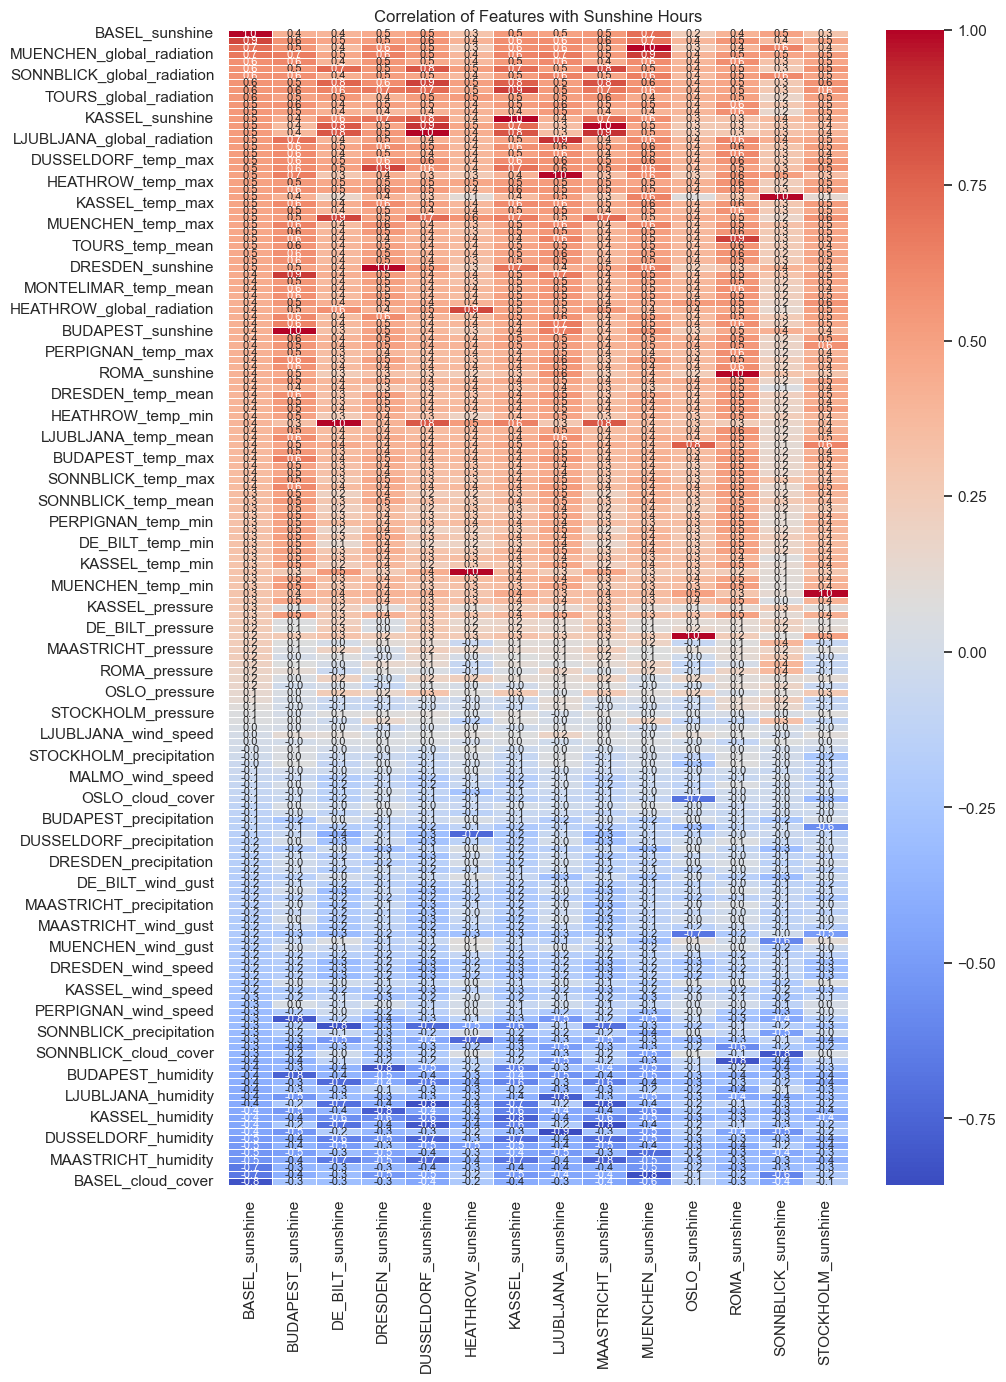

In [11]:
correlation_matrix = df_processed.corr()

plt.figure(figsize=(10, 15))
sns.heatmap(correlation_matrix[sunshine_cols].sort_values(by=sunshine_cols[0], ascending=False),
            annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation of Features with Sunshine Hours')

In [12]:
features = all_relevant_cols # Use all columns selected previously
target_cols = sunshine_cols   # List of target column names
num_targets = len(target_cols)
num_features = len(features) # Total number of features including targets

print(f"\nTotal features (including targets): {num_features}")
print(f"Number of target variables: {num_targets}")


Total features (including targets): 163
Number of target variables: 14


In [13]:
def create_multi_output_sequences(data, sequence_length, target_indices):
    X, y = [], []
    num_samples = len(data) - sequence_length
    for i in range(num_samples):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length, target_indices])
    return np.array(X), np.array(y)

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_processed)

df_scaled = pd.DataFrame(scaled_data, columns=features, index=df_processed.index)

In [15]:
SEQUENCE_LENGTH = 7 # Use past week's data
target_indices = [df_scaled.columns.get_loc(col) for col in target_cols]
X, y = create_multi_output_sequences(df_scaled.values, SEQUENCE_LENGTH, target_indices)

print(f"\nShape of input sequences (X): {X.shape}") 
print(f"Shape of target values (y): {y.shape}")  


Shape of input sequences (X): (3647, 7, 163)
Shape of target values (y): (3647, 14)


In [16]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## 5. LSTM Model Building


In [17]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=num_targets)) 

2025-04-28 14:31:04.754753: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-28 14:31:04.754783: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-28 14:31:04.754789: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-28 14:31:04.754824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-28 14:31:04.754837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            149504    
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 50)                1650      
                                                                 
 dense_1 (Dense)             (None, 14)                7

## 6. Model Training


In [19]:
EPOCHS = 100 
BATCH_SIZE = 64

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, 
    verbose=1
)

Epoch 1/100


2025-04-28 14:31:06.423232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:06.663336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:06.731233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:06.791450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:06.919238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:07.022483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/42 [==>...........................] - ETA: 0s - loss: 0.1406  

2025-04-28 14:31:07.122135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.0854

2025-04-28 14:31:08.131107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:08.215027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:08.259514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:31:08.304434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 3s 29ms/step - loss: 0.0854 - val_loss: 0.0683
Epoch 2/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0594 - val_loss: 0.0632
Epoch 3/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0576 - val_loss: 0.0625
Epoch 4/100
42/42 [==============================] - 1s 16ms/step - loss: 0.0557 - val_loss: 0.0593
Epoch 5/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0524 - val_loss: 0.0593
Epoch 6/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0532 - val_loss: 0.0539
Epoch 7/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0509 - val_loss: 0.0527
Epoch 8/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0493 - val_loss: 0.0506
Epoch 9/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0467 - val_loss: 0.0500
Epoch 10/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0466 - val_loss: 0.0502
Epoch 11/10

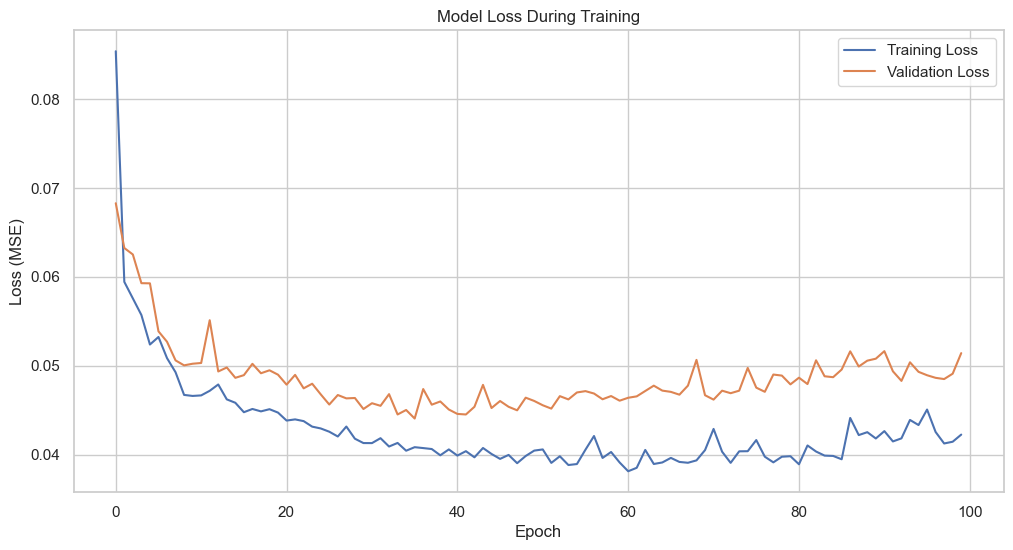

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

## 7. Model Evaluation


In [22]:
y_pred_scaled = model.predict(X_test) # Shape: (num_test_samples, num_targets)

scaled_means = np.mean(X_train.reshape(-1, num_features), axis=0) 

dummy_pred = np.tile(scaled_means, (len(y_pred_scaled), 1)) 
dummy_pred[:, target_indices] = y_pred_scaled 
y_pred_inv = scaler.inverse_transform(dummy_pred)[:, target_indices] 

dummy_test = np.tile(scaled_means, (len(y_test), 1))
dummy_test[:, target_indices] = y_test 
y_test_inv = scaler.inverse_transform(dummy_test)[:, target_indices] 

2025-04-28 14:32:06.944276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:32:07.026500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:32:07.074848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:32:07.121535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 5ms/step


In [23]:
results = {}
for i, target_name in enumerate(target_cols):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    results[target_name] = {'MAE': mae, 'RMSE': rmse}
    print(f"{target_name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f} hours")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f} hours")

BASEL_sunshine:
  Mean Absolute Error (MAE): 2.7233 hours
  Root Mean Squared Error (RMSE): 3.5047 hours
BUDAPEST_sunshine:
  Mean Absolute Error (MAE): 2.7210 hours
  Root Mean Squared Error (RMSE): 3.2695 hours
DE_BILT_sunshine:
  Mean Absolute Error (MAE): 2.7261 hours
  Root Mean Squared Error (RMSE): 3.4605 hours
DRESDEN_sunshine:
  Mean Absolute Error (MAE): 2.8608 hours
  Root Mean Squared Error (RMSE): 3.4973 hours
DUSSELDORF_sunshine:
  Mean Absolute Error (MAE): 2.5141 hours
  Root Mean Squared Error (RMSE): 3.2804 hours
HEATHROW_sunshine:
  Mean Absolute Error (MAE): 2.8590 hours
  Root Mean Squared Error (RMSE): 3.4817 hours
KASSEL_sunshine:
  Mean Absolute Error (MAE): 2.3543 hours
  Root Mean Squared Error (RMSE): 3.0250 hours
LJUBLJANA_sunshine:
  Mean Absolute Error (MAE): 2.4482 hours
  Root Mean Squared Error (RMSE): 3.0764 hours
MAASTRICHT_sunshine:
  Mean Absolute Error (MAE): 2.7210 hours
  Root Mean Squared Error (RMSE): 3.4035 hours
MUENCHEN_sunshine:
  Mean Abso

In [24]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_melted = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
results_melted = results_melted.rename(columns={'index': 'Location'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'BASEL_sunshine'),
  Text(1, 0, 'BUDAPEST_sunshine'),
  Text(2, 0, 'DE_BILT_sunshine'),
  Text(3, 0, 'DRESDEN_sunshine'),
  Text(4, 0, 'DUSSELDORF_sunshine'),
  Text(5, 0, 'HEATHROW_sunshine'),
  Text(6, 0, 'KASSEL_sunshine'),
  Text(7, 0, 'LJUBLJANA_sunshine'),
  Text(8, 0, 'MAASTRICHT_sunshine'),
  Text(9, 0, 'MUENCHEN_sunshine'),
  Text(10, 0, 'OSLO_sunshine'),
  Text(11, 0, 'ROMA_sunshine'),
  Text(12, 0, 'SONNBLICK_sunshine'),
  Text(13, 0, 'STOCKHOLM_sunshine')])

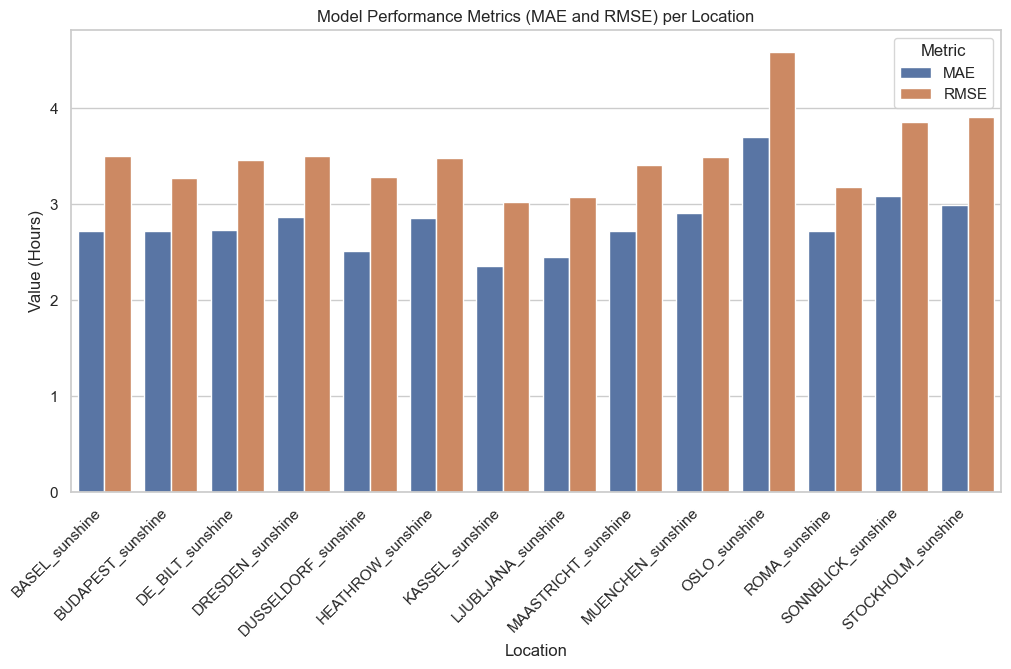

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Location', y='Value', hue='Metric', data=results_melted)
plt.title('Model Performance Metrics (MAE and RMSE) per Location')
plt.xlabel('Location')
plt.ylabel('Value (Hours)')
plt.xticks(rotation=45, ha='right')

Text(0, 0.5, 'RMSE (Hours)')

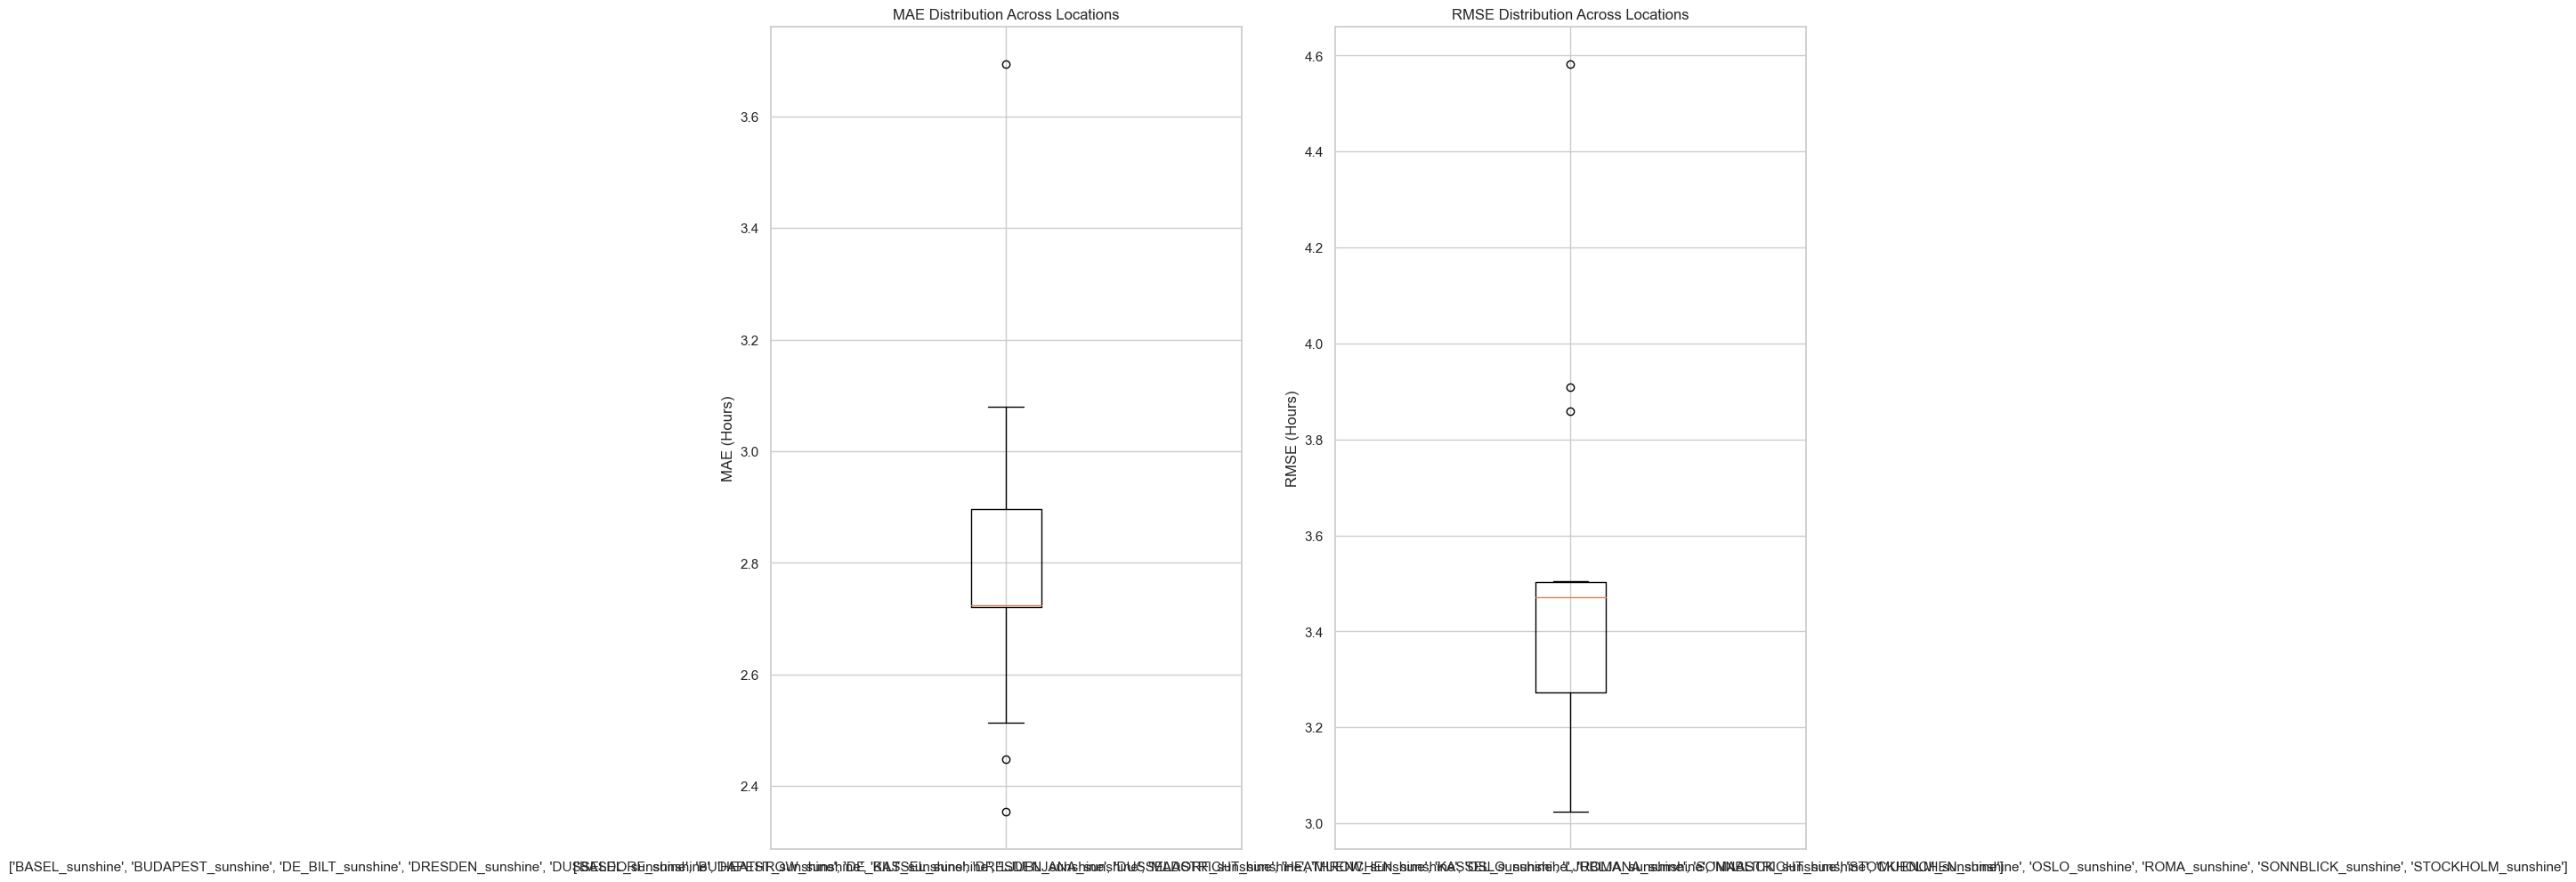

In [26]:
mae_values = [metrics['MAE'] for metrics in results.values()]
rmse_values = [metrics['RMSE'] for metrics in results.values()]
locations = list(results.keys())

plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
plt.boxplot(mae_values, labels=[locations])
plt.title('MAE Distribution Across Locations')
plt.ylabel('MAE (Hours)')

plt.subplot(1, 2, 2)
plt.boxplot(rmse_values, labels=[locations])
plt.title('RMSE Distribution Across Locations')
plt.ylabel('RMSE (Hours)')

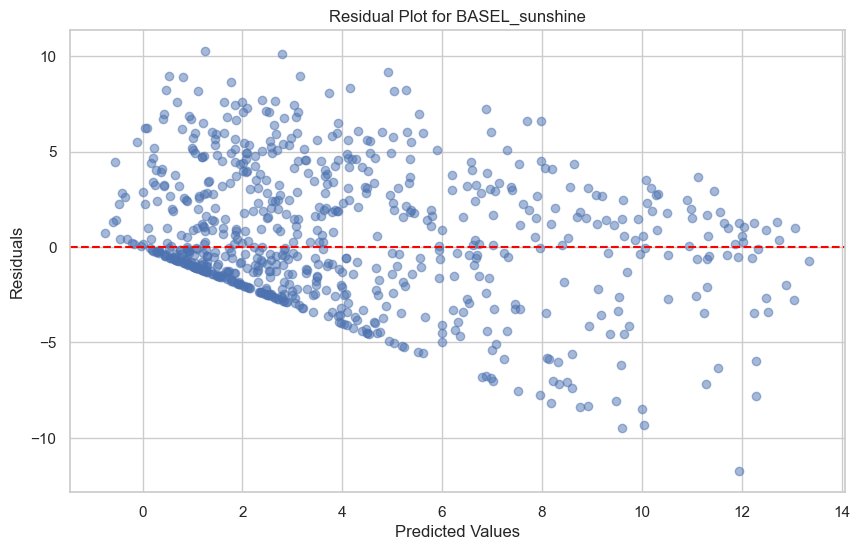

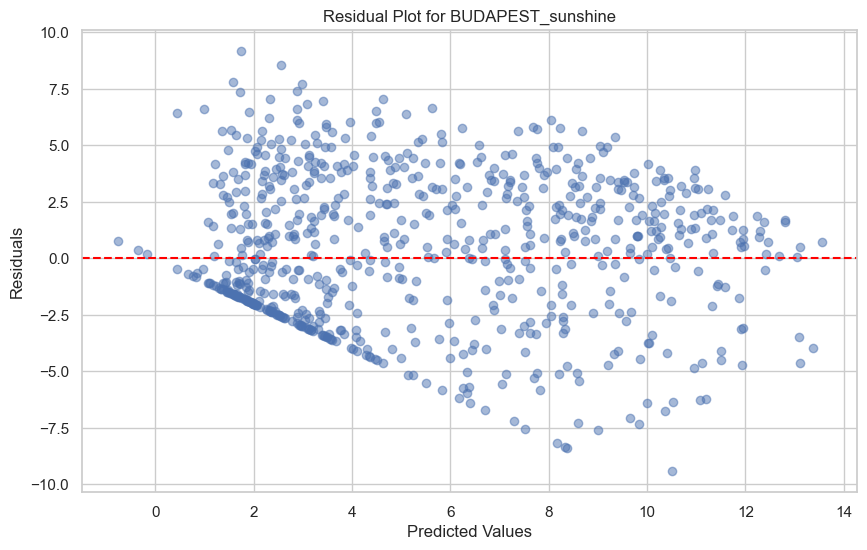

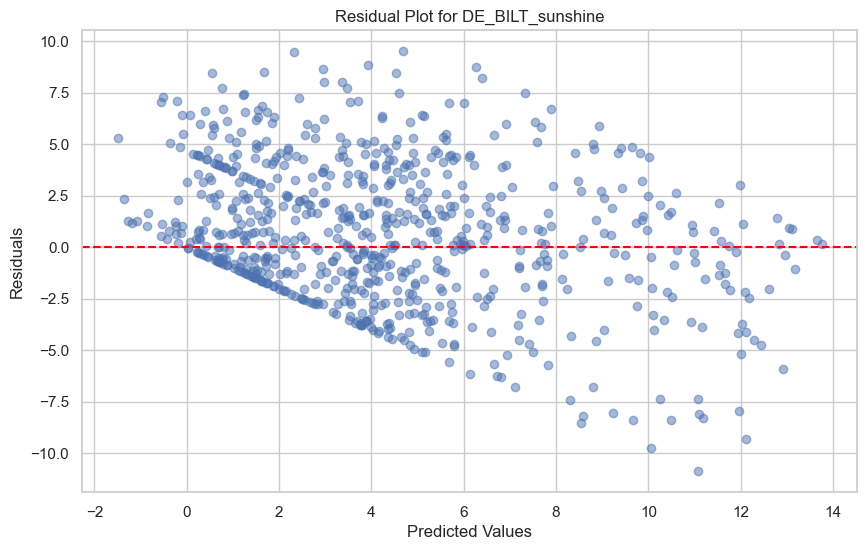

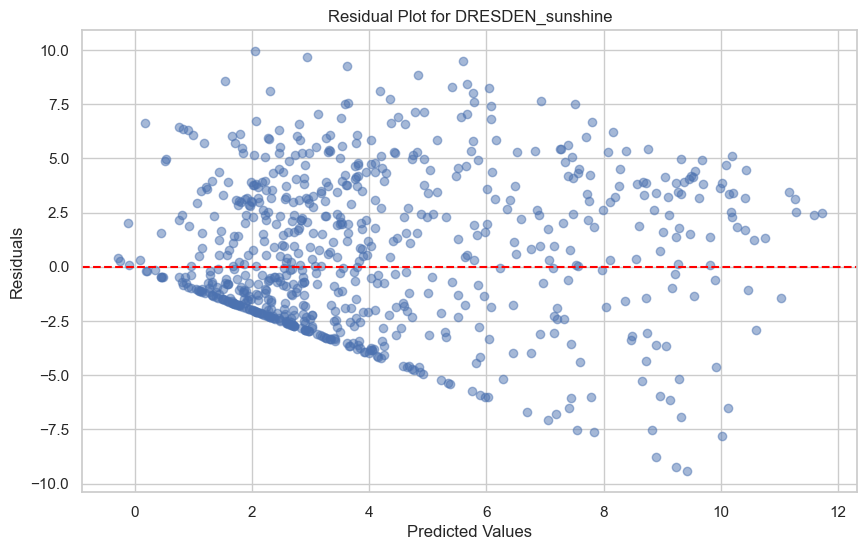

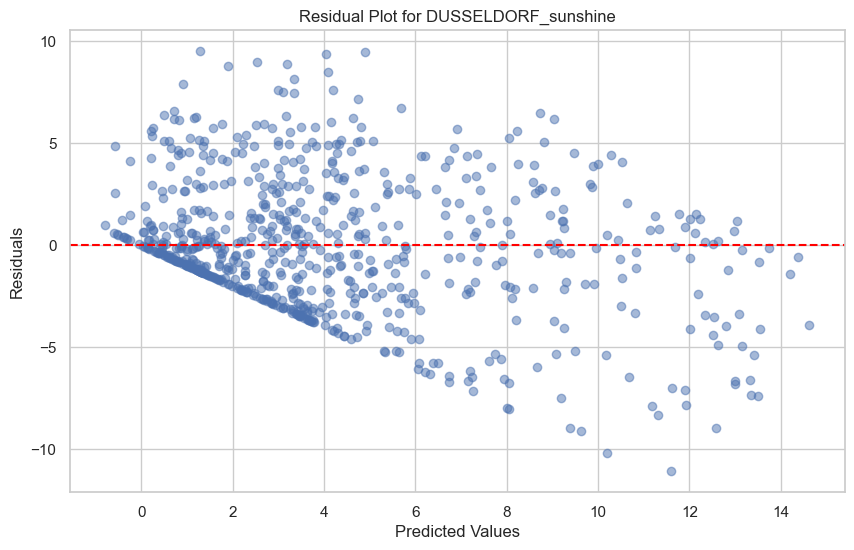

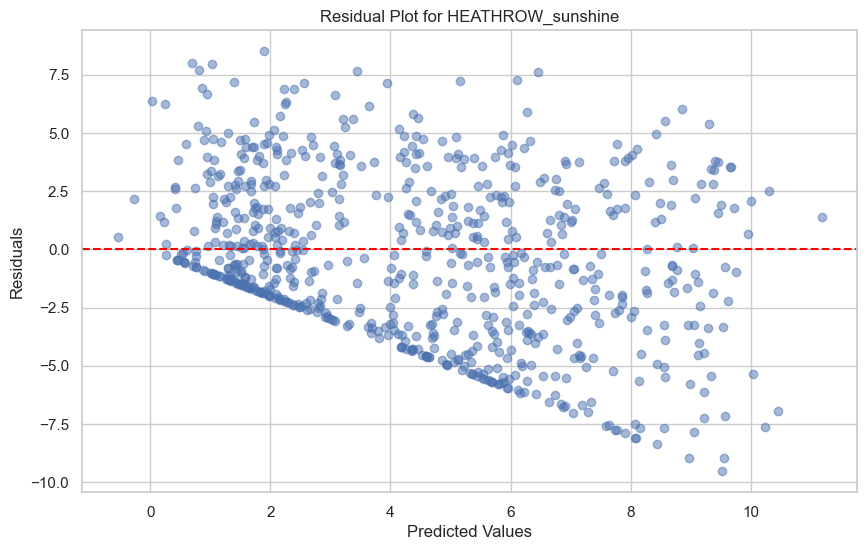

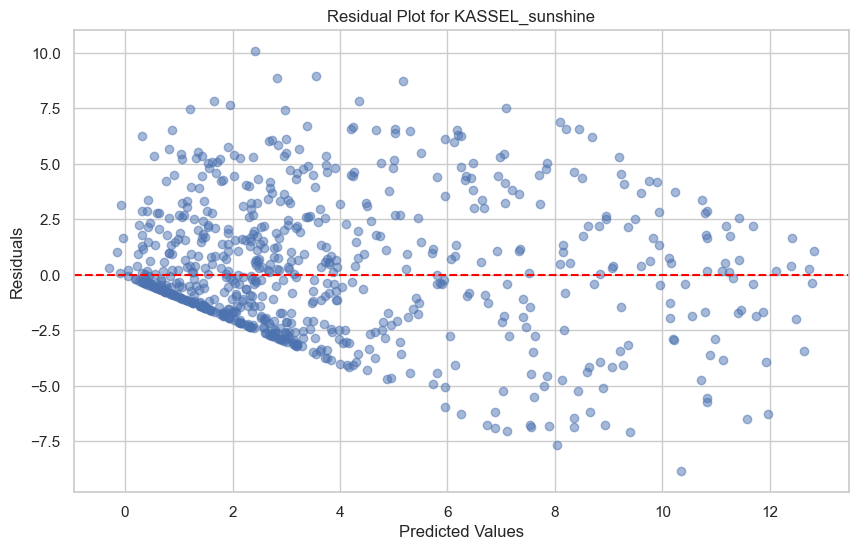

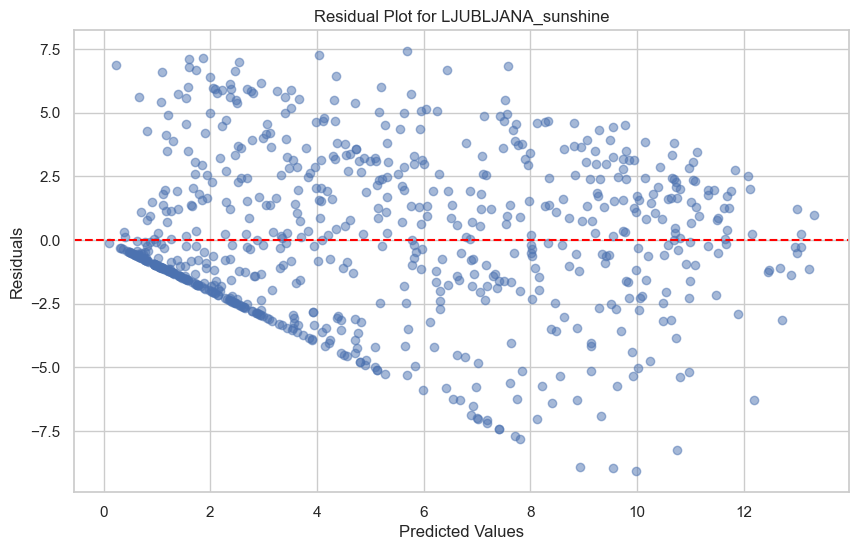

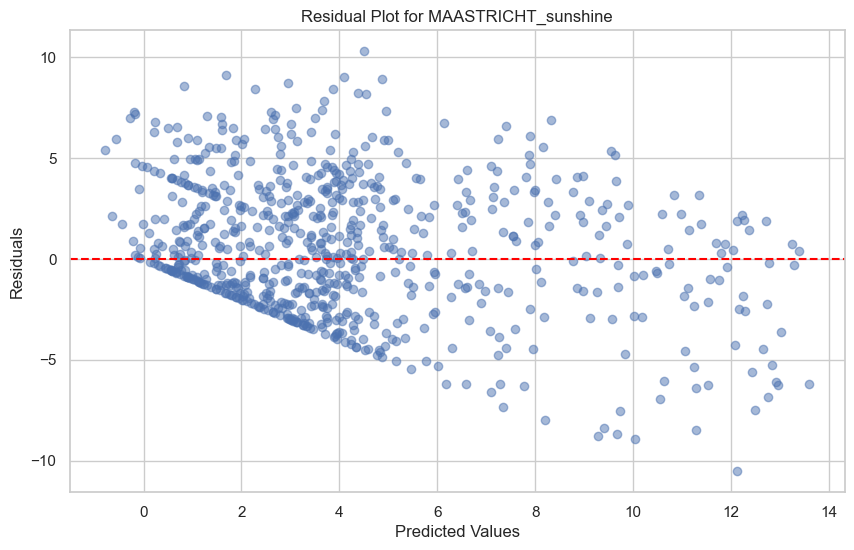

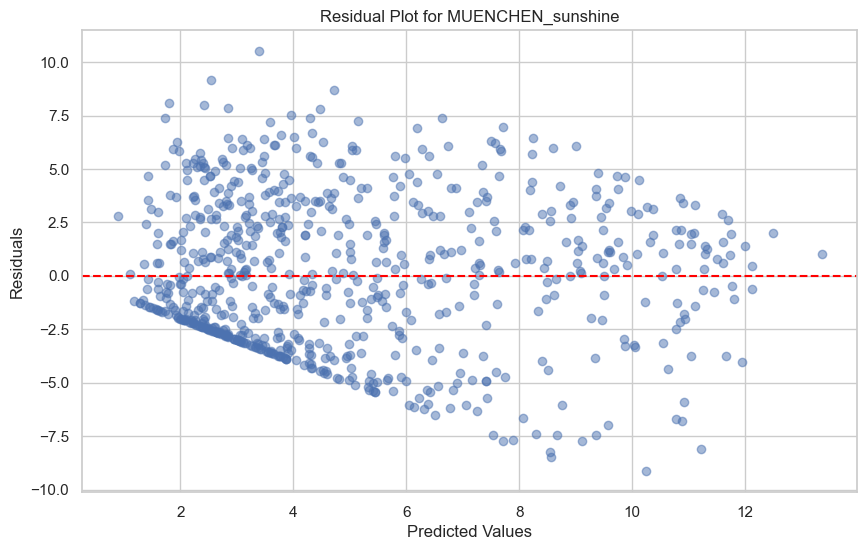

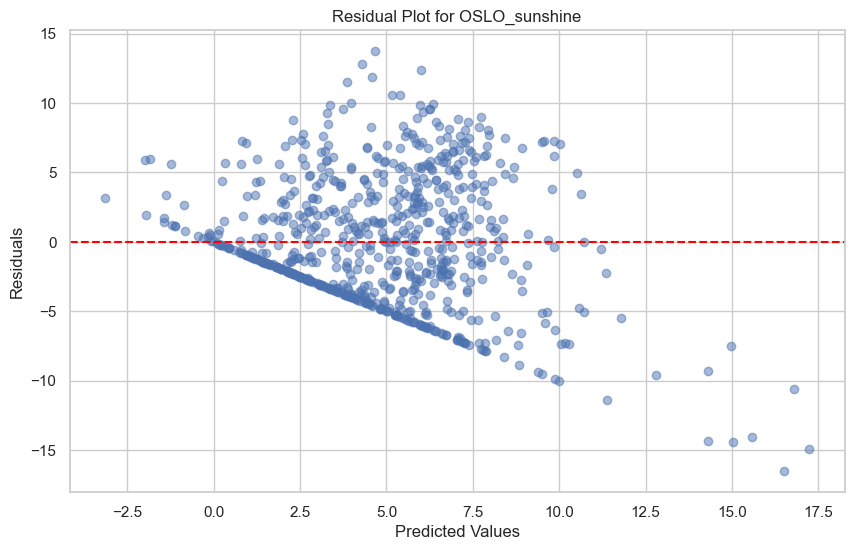

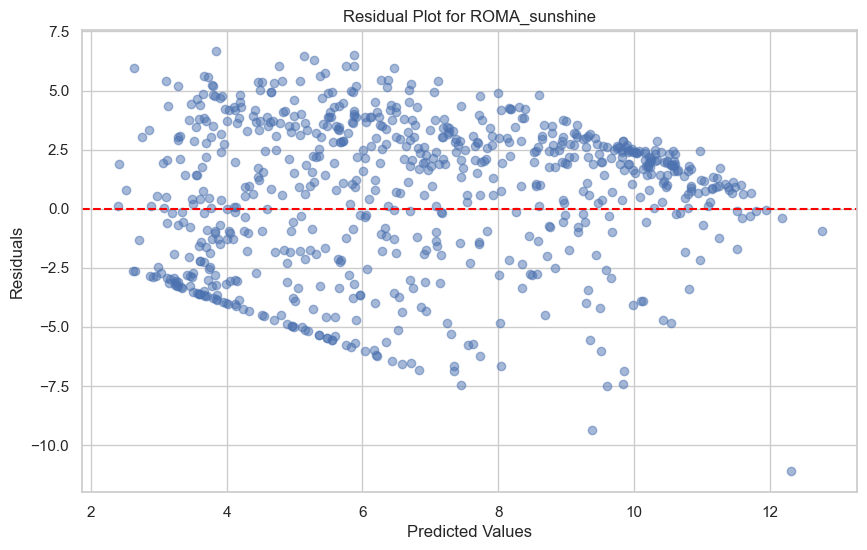

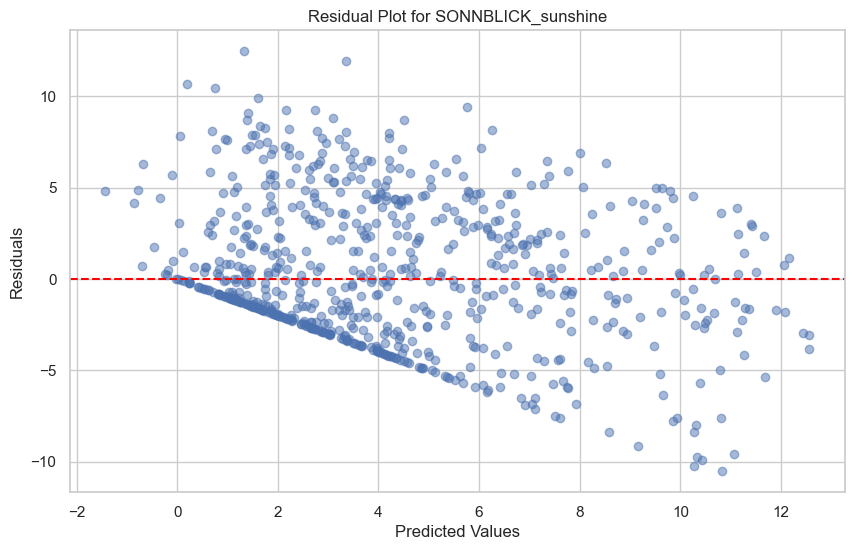

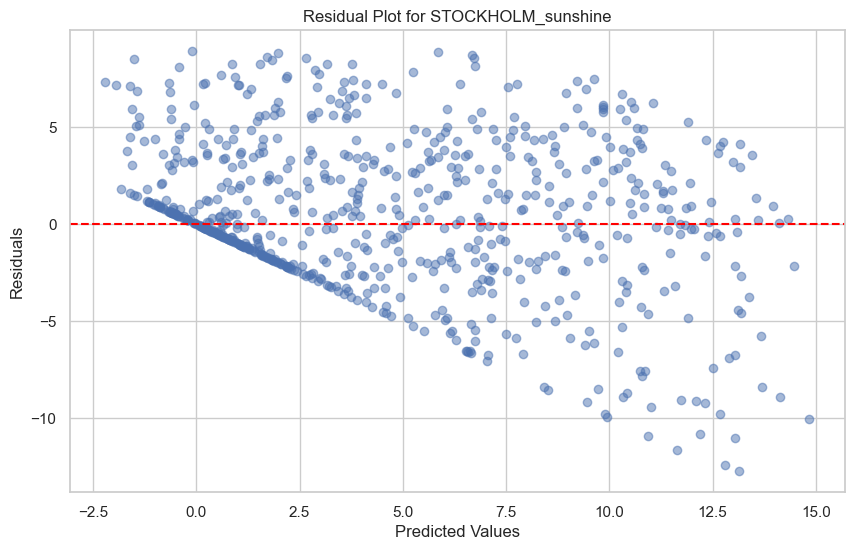

In [27]:
for i, target_name in enumerate(target_cols):
    residuals = y_test_inv[:,i] - y_pred_inv[:,i]

    plt.figure(figsize=(10,6))
    plt.scatter(y_pred_inv[:, i], residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for {target_name}')
    plt.grid(True)

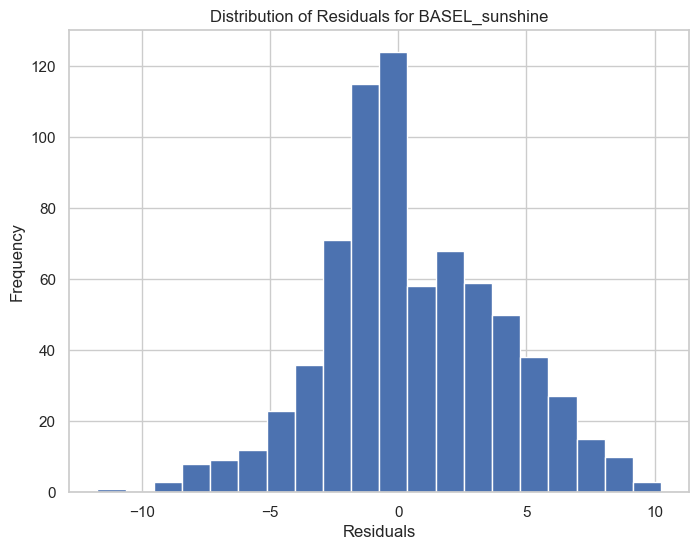

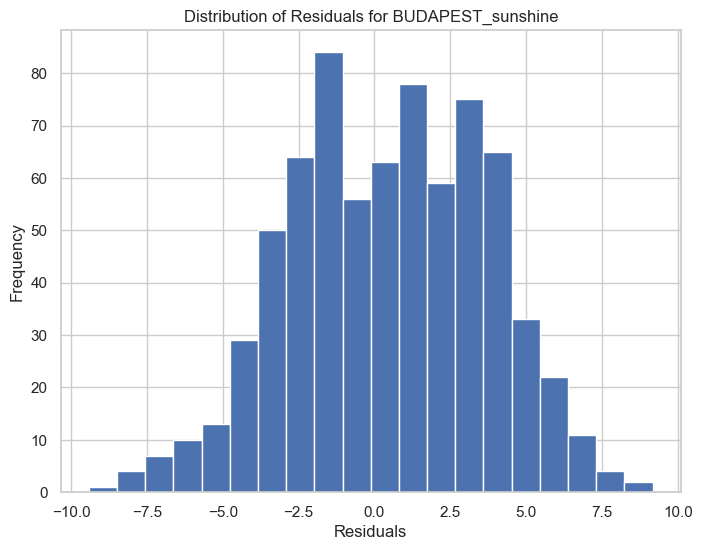

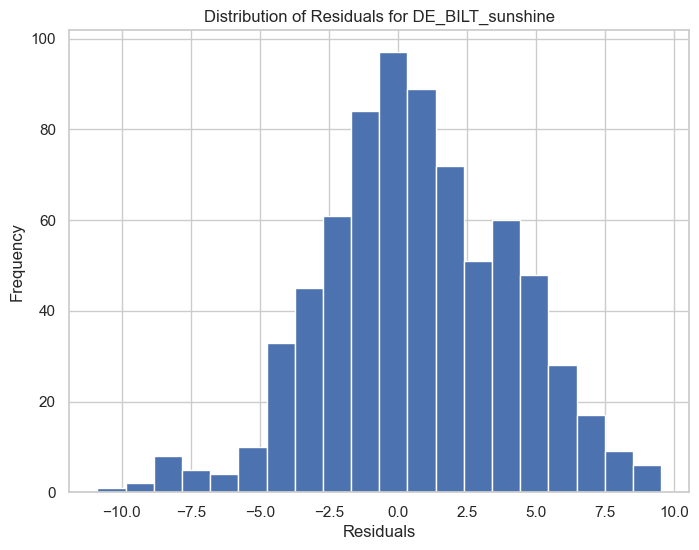

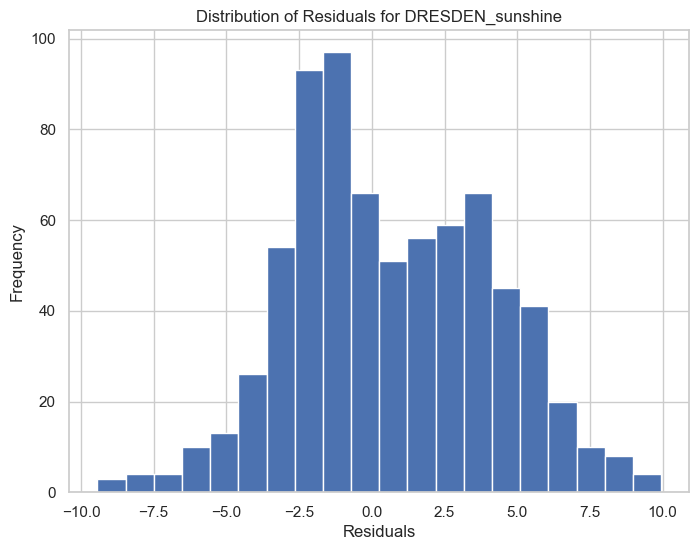

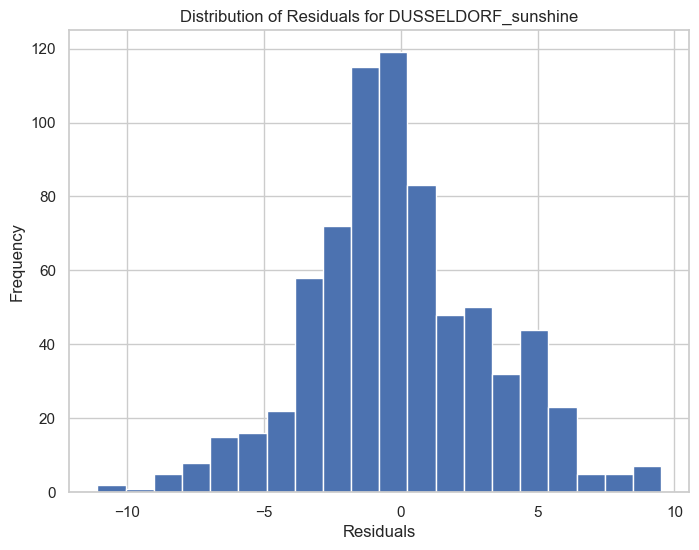

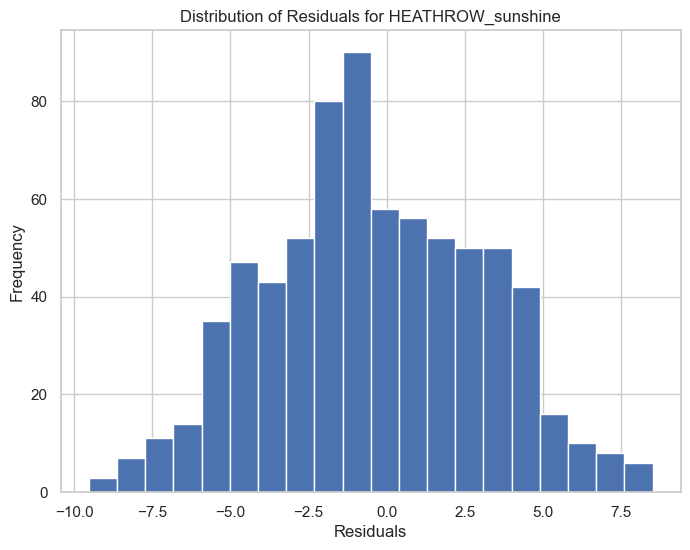

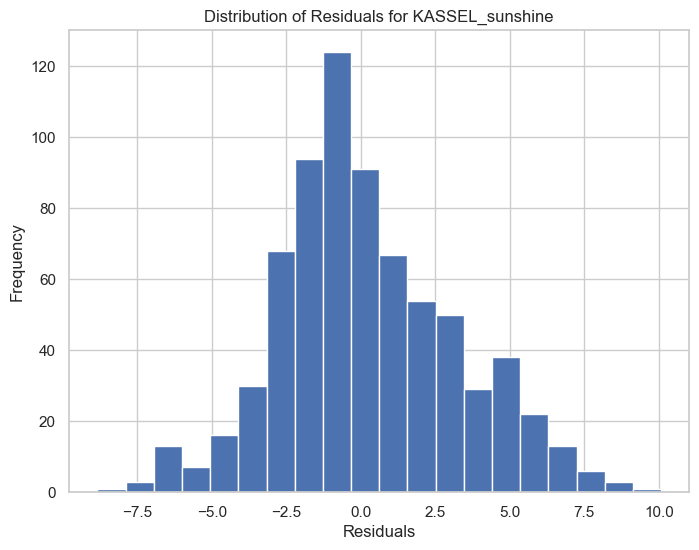

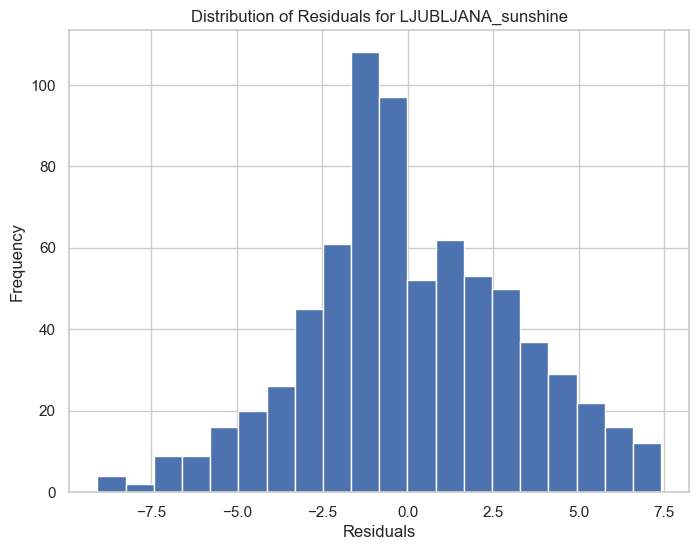

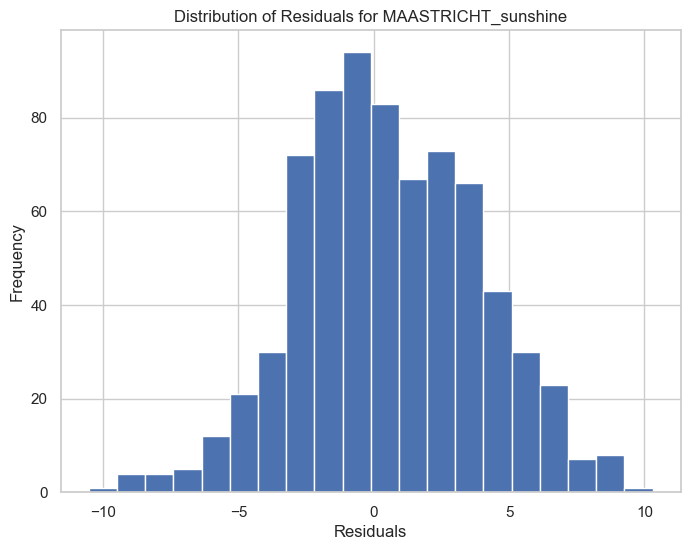

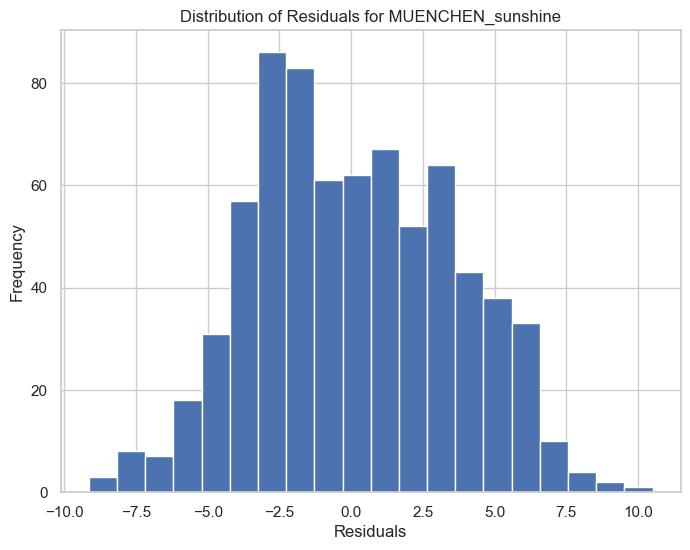

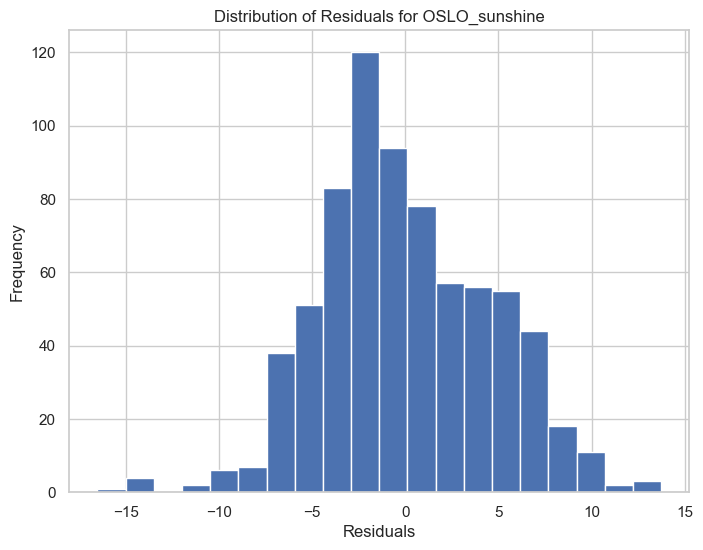

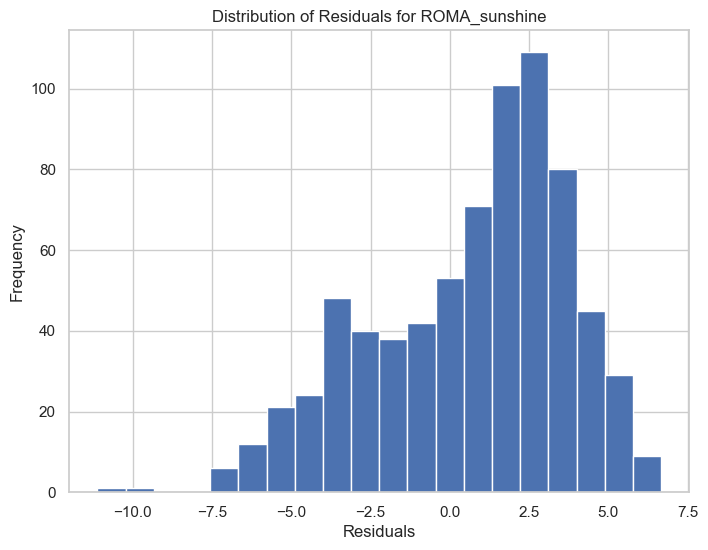

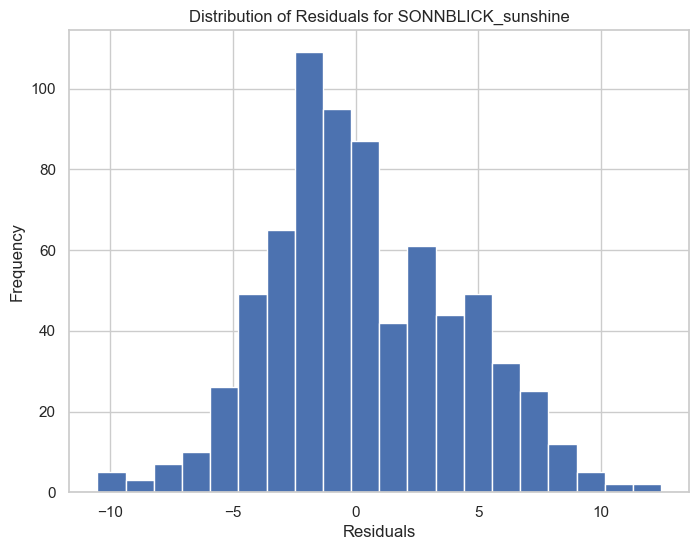

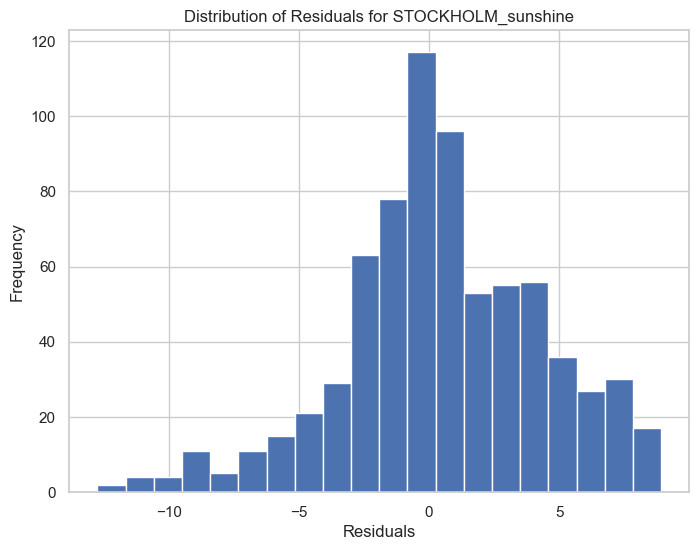

In [28]:
for i, target_name in enumerate(target_cols):
    residuals = y_test_inv[:, i] - y_pred_inv[:, i]
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=20)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Residuals for {target_name}')

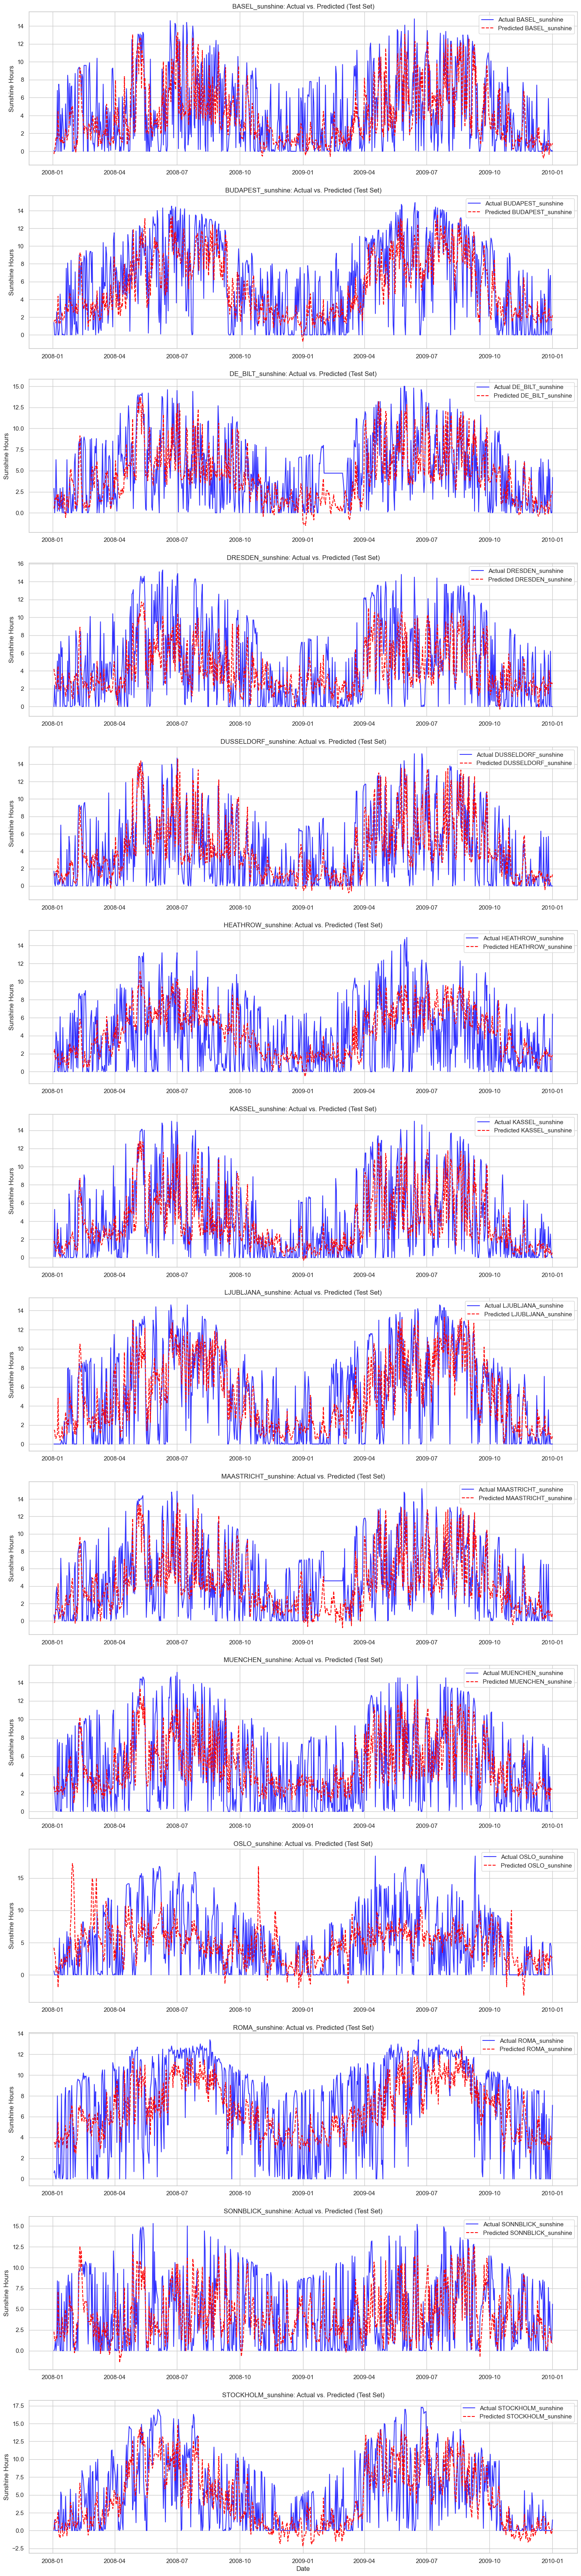

In [29]:
test_dates = df_processed.index[split_index + SEQUENCE_LENGTH:]

num_plots = len(target_cols)
plt.figure(figsize=(18, 6 * num_plots))

for i, target_name in enumerate(target_cols):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(test_dates, y_test_inv[:, i], label=f'Actual {target_name}', color='blue', alpha=0.8)
    plt.plot(test_dates, y_pred_inv[:, i], label=f'Predicted {target_name}', color='red', linestyle='--')
    plt.title(f'{target_name}: Actual vs. Predicted (Test Set)')
    plt.ylabel('Sunshine Hours')
    plt.legend()
    if i < num_plots - 1:
        plt.xlabel('')
    else:
        plt.xlabel('Date')